--------------------------------------------
**All information in ths notebook is licensed under the BSD 3-Clause "New" or "Revised" License. The license is found [here](https://github.com/jGaboardi/non-duplicated-intersects/blob/master/LICENSE).**

**If any part of this notebook is used in your research, please cite with the reference found in [README.md](https://github.com/jGaboardi/non-duplicated-intersects/blob/master/README.md#bibtex-citation).**

--------------------------------------------
# Non-duplicated intersects 
## Demonstrating an enhanced intersect operation with [sjoin in GeoPandas](http://geopandas.org/reference/geopandas.sjoin.html)
### Author: James D. Gaboardi jgaboardi@gmail.com
-----------------------------------
**This notebook demonstrates the strengths of combining the concepts of `within` and `intersects` for a non-duplicated `intersects` version of spatial join. This method can be thought of as "point-associated-with-polygon," because it captures the spatial relationship of points contained within a polygon and touching the exterior of the polygon, while preserving the cardinality of the original point set, $|P| = |P^\prime|$.**

### Overview

1. **Defined Globals and Functions**
2. **Generating synthetic data**
3. **Demonstrating `within`**
4. **Demonstrating `intersects`**
5. **Demonstrating non-duplicated `intersects` (`nd-intersects`)**

In [1]:
%load_ext watermark
%watermark

2020-01-22T16:56:26-05:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import geopandas
import matplotlib
import shapely
import string
from shapely.geometry import Point, Polygon
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina", quality=100)
except ImportError:
    pass
%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
shapely    1.6.4.post2
geopandas  0.6.2
matplotlib 3.1.2



---------------------------------------
## 1. Defined Globals and Functions
### Globals

In [3]:
PTID = "point_id"
PGID = "polygon_id"
GEOM = "geometry"
KEEP_COLUMNS = [PTID, PGID, GEOM]
NAN = "NaN"
HOW = "left"
WITHIN = "within"
INTERSECTS = "intersects"

### Functions

In [4]:
def nd_intersects(pnts, pgons):
    """Create a non-duplicated intersects geodataframe.
    
    Parameters
    ----------
    pnts : geopandas.GeoDataFrame
        Points for spatial join.
    pgons : geopandas.GeoDataFrame
        Polygons for spatial join.
    how : str
        Type of join to perform.
    Returns
    -------
    ndgdf : geopandas.GeoDataFrame
        Result of the non-duplicated intersects method.
    """
    
    # perform "intersects" spatial join
    igdf = do_sjoin(points, polygons, INTERSECTS)
    
    # Create shell dataframe to store squashed intersection points
    index = range(pnts[PTID].nunique())
    ndgdf = geopandas.GeoDataFrame(columns=igdf.columns, index=index)
    
    # Iterate over a grouby object to populate
    # the squashed intersection points
    for idx, (pid, group) in enumerate(igdf.groupby(PTID)):
        ndgdf.loc[idx, PTID] = pid
        ndgdf.loc[idx, PGID] = "-".join(group[PGID])
        ndgdf.loc[idx, GEOM] = group[GEOM].unique()
    
    return ndgdf

In [5]:
def do_sjoin(df1, df2, op):
    """Perform a spatial join in GeoPandas.
    
    Parameters
    ----------
    df1 : geopandas.GeoDataFrame
        Left geodataframe for the spatial join.
    df2 : geopandas.GeoDataFrame
        Right geodataframe for the spatial join.
    op : str
        Binary predicate in Shapley.
        https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates
    
    Returns
    -------
    df3 : 
        Result of the spatial join
    """
    
    df3 = geopandas.sjoin(df1, df2, how=HOW, op=op)
    df3 = df3.copy()[KEEP_COLUMNS]
    # Fill actual NaN with "NaN" for plotting purposes
    df3.loc[(df3[PGID].isna()), PGID] = NAN
    
    return df3

In [6]:
def plot_join(pnts, pgons, title, orig, save=None, cmap="Paired", fmat="png"):
    """Plot a spatial join from this notebook.
    
    Parameters
    ----------
    pnts : geopandas.GeoDataFrame
        Points for spatial join.
    pgons : geopandas.GeoDataFrame
        Polygons for spatial join.
    title : str
        Supertitle of the plot.
    orig : int
        Set cardinality of original point set, $|P|$.
    save : str
        File name (including path) plot output. Default is None.
    cmap : str
        Default is 'Paired'.
        https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    fmat : str
        Format for saving `savefig`. Default is 'png'.
    """
    
    def pgon_labels(p):
        """label polygons"""
        def _loc(_x):
            """polygon label location helper"""
            return [coord+.35 for coord in _x[GEOM].centroid.coords[0]]
        kws = {"size":25, "va":"bottom"}
        p.apply(lambda x: base.annotate(s=x[PGID], xy=_loc(x), **kws), axis=1)
    
    def pt_labels(p):
        """label points with PTID+PGID"""
        def _lab(_x):
            """point label helper"""
            return ",".join([_x[PTID], _x[PGID]])
        def _loc(_x):
            """point label location helper"""
            return _x[GEOM].coords[0]
        kws = {"size":15, "va":"bottom", "weight":"bold"}
        p.apply(lambda x: base.annotate(s=_lab(x), xy=_loc(x), **kws), axis=1)
    
    def add_title(label, sup=True):
        """add a suptitle or title"""
        if sup:
            matplotlib.pyplot.suptitle(label, x=0.515, y=.98, fontsize=30)
        else:
            matplotlib.pyplot.title(label, fontsize=20)
    
    def set_card():
        """Determine equality of set cardinality for subtitle"""
        sj_pnts = pnts.shape[0]
        if orig == sj_pnts:
            oper = "="
        elif orig < sj_pnts:
            oper = "<"
        elif orig > sj_pnts:
            oper = ">"
        else:
            raise ValueError("Equality could not be determined.") 
        return "$\\vert P \\vert %s \\vert P^\\prime \\vert$" % oper
    
    base = pgons.plot(figsize=(8,8), zorder=0, facecolor="w", edgecolor="k")
    pnts.plot(ax=base, markersize=50, column=PGID, cmap=cmap)
    
    # polygons labeled with "polygon_id"
    pgon_labels(pgons)
    
    # points labeled with "point_id" and "polygon_id"
    pt_labels(pnts)
    
    # add title
    add_title(title)
    
    # add subtitle
    add_title(set_card(), sup=False)
    
    # save figure
    if save:
        kws = {"bbox_inches":"tight", "format":fmat, "dpi":400, "quality":100}
        matplotlib.pyplot.savefig("%s.%s" % (save, fmat), **kws);

----------------------------------------
## 2. Synthetic Data
### Synthetic points

In [7]:
point_coords = [(-1,-1), (0,-1), (.5,-.75), (-.5,-.5), (.5,-.5), (0,0), (.5,.5)]
point_ids = {PTID:list(string.ascii_uppercase[:len(point_coords)])}
points = [Point(coords) for coords in point_coords]
points = geopandas.GeoDataFrame(point_ids, geometry=points)
points

,point_id,geometry
0,A,POINT (-1.00000 -1.00000)
1,B,POINT (0.00000 -1.00000)
2,C,POINT (0.50000 -0.75000)
3,D,POINT (-0.50000 -0.50000)
4,E,POINT (0.50000 -0.50000)
5,F,POINT (0.00000 0.00000)
6,G,POINT (0.50000 0.50000)


In [8]:
n_points = points.shape[0]

### Synthetic polygons

In [9]:
polygon_coords = [
    [(-1,-1), (0,-1), (0,0), (-1,0)],
    [(0,-1), (1,-1), (1,0), (0,0)],
    [(-1,0), (0,0), (0,1), (-1,1)]
]
polygons = [Polygon(coords) for coords in polygon_coords]
polygon_ids = {PGID:list(string.ascii_lowercase[-len(polygon_coords):])}
polygons = geopandas.GeoDataFrame(polygon_ids, geometry=polygons)
polygons

,polygon_id,geometry
0,x,"POLYGON ((-1.00000 -1.00000, 0.00000 -1.00000,..."
1,y,"POLYGON ((0.00000 -1.00000, 1.00000 -1.00000, ..."
2,z,"POLYGON ((-1.00000 0.00000, 0.00000 0.00000, 0..."


----------------------------------------------------
## 3. Perform left spatial join and plot — `within`
**The issue with a `within` operation is a point that exactly intersects a polygon exterior (`touch`) is not contained in the polygon and, therefore, not included in the spatial join.**

In [10]:
within_df = do_sjoin(points, polygons, WITHIN)
within_df

,point_id,polygon_id,geometry
0,A,NaN,POINT (-1.00000 -1.00000)
1,B,NaN,POINT (0.00000 -1.00000)
2,C,y,POINT (0.50000 -0.75000)
3,D,x,POINT (-0.50000 -0.50000)
4,E,y,POINT (0.50000 -0.50000)
5,F,NaN,POINT (0.00000 0.00000)
6,G,NaN,POINT (0.50000 0.50000)


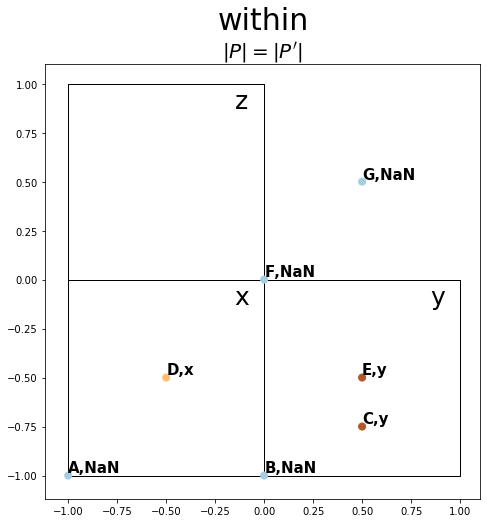

In [11]:
plot_join(within_df, polygons, WITHIN, n_points, save=WITHIN)

-------------------------
## 4. Perform left spatial join and plot — `intersects`
**The issue with an `intersects` operation is a point that exactly intersects multiple polygon exteriors (`touch`) is duplicated for each polygon it intersects and, thus, increases the set cardinality.**

In [12]:
intersects_df = do_sjoin(points, polygons, INTERSECTS)
intersects_df

,point_id,polygon_id,geometry
0,A,x,POINT (-1.00000 -1.00000)
1,B,x,POINT (0.00000 -1.00000)
1,B,y,POINT (0.00000 -1.00000)
2,C,y,POINT (0.50000 -0.75000)
3,D,x,POINT (-0.50000 -0.50000)
4,E,y,POINT (0.50000 -0.50000)
5,F,x,POINT (0.00000 0.00000)
5,F,y,POINT (0.00000 0.00000)
5,F,z,POINT (0.00000 0.00000)
6,G,NaN,POINT (0.50000 0.50000)


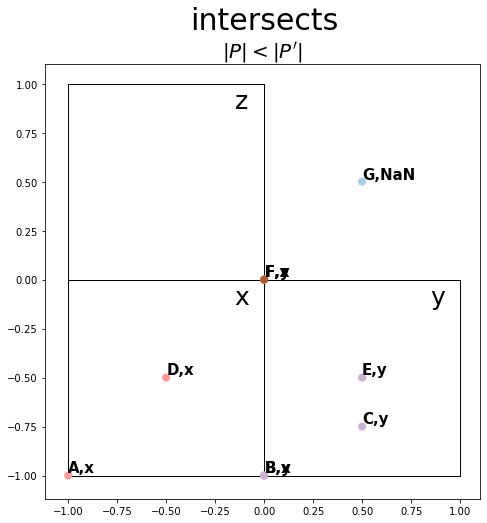

In [13]:
plot_join(intersects_df, polygons, INTERSECTS, n_points, save=INTERSECTS)

-------------------------------------
## 5. Solution: a non-duplicated intersects operation
### This method has two benefits:
* **polygon attribute values are squashed into one label, which can be extracted later; and**
* **the set cardinality of the original dataset is preserved**

In [14]:
nd_intersects_df = nd_intersects(points, polygons)
nd_intersects_df

,point_id,polygon_id,geometry
0,A,x,POINT (-1.00000 -1.00000)
1,B,x-y,POINT (0.00000 -1.00000)
2,C,y,POINT (0.50000 -0.75000)
3,D,x,POINT (-0.50000 -0.50000)
4,E,y,POINT (0.50000 -0.50000)
5,F,x-y-z,POINT (0.00000 0.00000)
6,G,NaN,POINT (0.50000 0.50000)


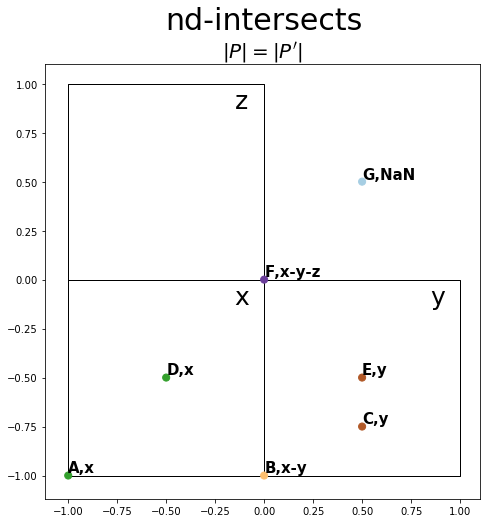

In [15]:
plt_title = "nd-%s" % INTERSECTS
plot_join(nd_intersects_df, polygons, plt_title, n_points, save=plt_title)

------------------